<a href="https://colab.research.google.com/github/rlsummerschool/practical-sessions/blob/master/notebooks/bandits_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bandit Algorithms

This practical session of [RLSS 2023](https://rlsummerschool.com/) is based on the lectures:
* Stochastic Multi-Armed Bandits by Emilie Kaufmann ([slides](https://drive.google.com/file/d/1CXrOd8Ltc5x9QmAGmxNWaYmWgZY5V2kJ/view?usp=sharing))
* Contextual Bandits by Claire Vernade ([slides](https://drive.google.com/file/d/11G6_mvo9DY1nQR3qsZ6X__3TpPTcBFXH/view?usp=sharing))

It was developed by [Julia Olkhovskaya](https://sites.google.com/view/julia-olkhovskaya/home) and Matteo Papini building upon notebooks by Claire Vernade.

As a motivation for this tutorial, we consider the multiple choice testing for the webpage design problem.

<br><br>

<div>
    <img src="https://github.com/rlsummerschool/practical-sessions/blob/master/images/website.jpg?raw=true" width="500"/>
</div>

<br><br>

Good design of a webpage is not only about the matching colours and useful
interfaces. Even if one website
design seems to be the most rational for the designer, it is usually hard to
predict which webpage design users will like the most. Therefore, the
important part of the webpage design is the testing on the real users.
Since displaying the webpage with bad design means the loss of the money,
we need to develop a mecanism that chooses the page design that is
the best most of time.

*Your goal is to build a decision support system which chooses the website design at each time step without any prior knowledge.*

In [1]:
# Set up the environment
!pip install "git+https://github.com/rlsummerschool/practical-sessions.git" --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Some standard imports
import numpy as np
from scipy.stats import bernoulli
from math import log
import random
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn-v0_8')

In [3]:
# Some imports from our github repository (https://github.com/rlsummerschool/practical-sessions/tree/master)
from rlss_practice.model import Environment, Agent, MAB_env
import rlss_practice.model
from rlss_practice.display import plot_result
import rlss_practice.bandit_solutions as solutions

# Part 1 &mdash; Multi-Armed Bandits

We formulate the choice design of a webpage design as a multi-armed bandit problem.  We
will use the synthetically generated “visits” of users, for each user the system will recommend the version of the website, so each version of the website is an arm. We model the engagement score (~#clicks) corresponding to the of version of the website as a Gaussian random variable.

## Interaction protocol
Let's recall Emilie's lecture from yesterday. An (adaptive) agent interacts with an unknown environment for $T$ rounds. At each round $t$:

* The agent picks an arm (action) $A_t$ from a set of $K$ actions
* The agent receives a reward $R_t \sim \nu_{A_t}$

where $\nu_{a}$ is an *unknown* distribution with mean $\mu_a$. In our case, it's a Gaussian distribution *with standard deviation $\sigma=1$ for all arms*:

$R_t \sim \mathcal{N}(\mu_a, 1)$

The goal is to maximize total reward $\sum_{t=1}^TR_t$.

Here is some code to play a bandit algorithm (adaptive agent) in a MAB environment, and to compare the performance on different algorithms on the same problem.

In [4]:
def play_mab(environment, agent, N, T):
    """
    Play N independent runs of length T for the specified agent.

    :param environment: a MAB instance
    :param agent: a bandit algorithm
    :param N: number of independent simulations
    :param T: decision horizon
    :return: the agent's name, and the collected data in numpy arrays
    """

    rewards = np.zeros((N, T))
    regrets = np.zeros((N, T))
    pseudo_regrets = np.zeros((N, T))
    avg_rewards = np.zeros((N, T))

    for n in range(N):
        agent.reset()
        for t in range(T):
            action = agent.get_action()
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instantaneous reward  and (pseudo) regret
            rewards[n,t] = reward
            means = environment.get_means()
            best_reward = np.max(means)
            regrets[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive
            avg_rewards[n,t] = means[action]
            pseudo_regrets[n,t] = best_reward - means[action]

    return agent.name(), rewards, regrets, avg_rewards, pseudo_regrets


def experiment_mab(environment, agents, N, T, mode="regret"):
    """
    Play N trajectories for all agents over a horizon T. Store data in a dictionary.

    :param environment: a MAB instance
    :param agent: a list of bandit algorithms to compare
    :param N: number of independent simulations
    :param T: decision horizon
    :param mode: the performance measure to return ("reward", "average reward", "regret", "pseudo regret")
    :return: the performance for each agent in a dictionary indexed by the agent's name
    """

    all_data = {}

    for agent in agents:
        agent_id, rewards, regrets, avg_rewards, pseudo_regrets = play_mab(environment, agent, N, T)

        if mode == "regret":
            all_data[agent_id] = regrets
        elif mode == "pseudo regret":
            all_data[agent_id] = pseudo_regrets
        elif mode == "reward":
            all_data[agent_id] = rewards
        elif mode == "average reward":
            all_data[agent_id] = avg_rewards
        else:
            raise ValueError

    return all_data

Our MAB environment has 3 arms (three possible website designs). We will run online algorithms for $T=1000$ steps (corresponding to 1000 users visiting the website in sequence) and average results over $N=50$ independent runs.

In [5]:
K = 3  # number of arms (website versions)

env = MAB_env(solutions.MEANS) #We don't know the reward distributions in advance!

T = 1000  # Horizon
N = 50  # number of simulations

# Visualization
Nsub = 100 # Subsampled points
tsav = range(2, T, Nsub)

## Exercise 1.A &mdash; (Epsilon) Greedy
**tl;dr**
> $A_t = \arg\max_{a\in\{1,\dots,K\}} \widehat{\mu}_a(t-1)$ with probability $1-\epsilon$
>
> $A_t \sim \mathrm{Uniform}(1,\dots,K)$ otherwise

Let's start with the $\epsilon$-greedy algorithm, where $\epsilon$ is an "exploration" parameter.

📖 The way $\epsilon$-greedy selects actions is

$A_t = \arg\max_{a\in\{1,\dots,K\}} \widehat{\mu}_a(t-1)$ with probability $1-\epsilon$

$A_t \sim \mathrm{Uniform}(1,\dots,K)$ otherwise

Where $\widehat{\mu}_a(t-1)$ is the average reward for arm $a$ up to time $t-1$ included.

You are given an *incomplete* implementation of $\epsilon$-greedy that actually implements the Greedy algorithm ($\epsilon=0$). This code already includes computation of average rewards!

Your task is to:
* Complete the implementation of $\epsilon$-greedy [(hint)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)
* Find a good value of $\epsilon$ for our 3-arms problem
* Compare the regret with Greedy ($\epsilon=0$)
* 💪 **Bonus question:** Implement a version of $\epsilon$-greedy where the exploration parameter changes with time, as seen in Emilie's lecture. Does it work better?

🎁 For all (non-bonus) questions you can try our **solution** by accessing the classes in `solutions`. For instance, our implementation of EpsilonGreedy is `solution.EpsilonGreedy`

In [6]:
class EpsilonGreedy(Agent):
  """
  Epsilon-Greedy MAB algorithm

  :param K: number of arms
  :param eps: exploration probability
  """
  def __init__(self, K, eps=0.):
    self.eps = eps
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)


  def reset(self):
    """Reset history before each independent run"""
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)

  def get_action(self):
    """
    Select the arm to play based on current history

    :return: the selected arm (an integer between 0 and K-1)
    """
    # YOUR CODE HERE:
    # TODO: Add some instructions to turn Greedy into epsilon-Greedy

    ...

    # END OF YOUR CODE

    chosen_arm_index = np.argmax(self.avg_rewards)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (counts and average rewards)

    :param chosen_arm: the arm that was played
    :param reward: the reward that was received
    """
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm] # update

    self.t += 1

  def name(self):
    return 'EGreedy('+str(self.eps)+')'

First let's see how we can visualize the result of an algorithm, using Greedy as an example

In [7]:
greedy = EpsilonGreedy(K,  eps=0.)

🤓 What we can measure **in a real bandit application** is just the rewards of the selected arms! This is the nature of bandit feedback.

Results are averaged over the N runs. In a real online application, there is *only one run!*

The `q` parameter of `plot_result` specifies the quantile of the error bars (shaded area)

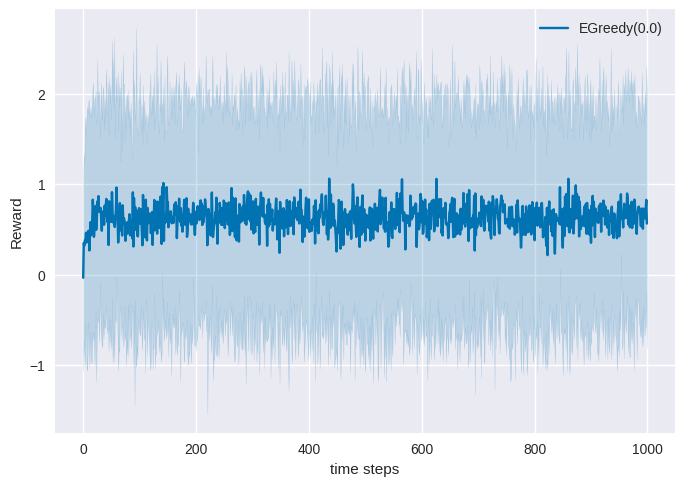

In [8]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="reward")

plot_result(greedy_experiment, q=10, mode="reward", cumulative=False);

For better visualization, we can also sum rewards over time

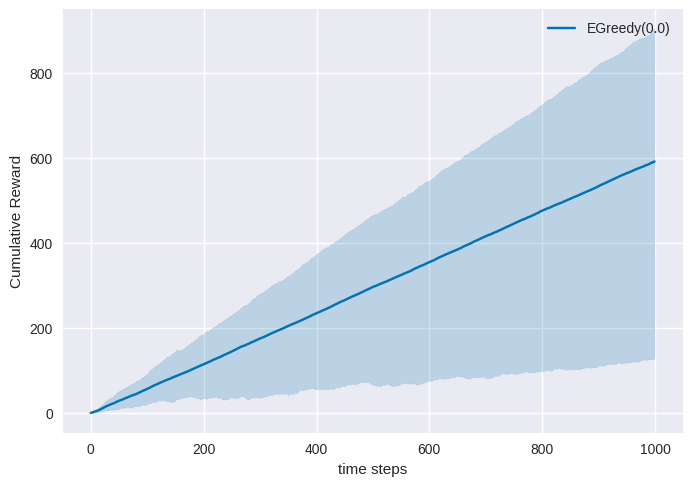

In [9]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="reward")
plot_result(greedy_experiment, q=10, mode="reward", cumulative=True);

In research experiments, we often test algorithms on known distribution. This allows us to compute the (cumulative) regret:

$\mathcal{R}(T) = T\mu_\star - \sum_{t=1}^TR_t$

Of course the agent doesn't have acces to this information, neither would we in a real application.

⚠️ Remember that **smaller regret is always better** when comparing algorithms.

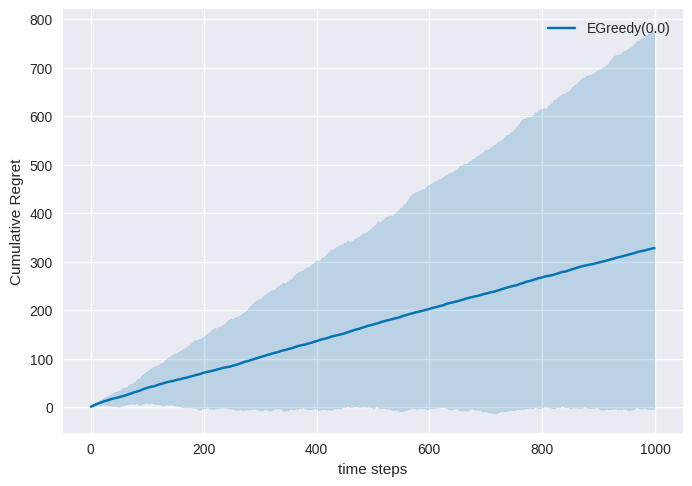

In [10]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="regret")
plot_result(greedy_experiment, q=10, mode="regret");

Finally, we can ignore the noise in the rewards and compute the **pseudo regret** instead (again, only in a controlled experiment):

$\widetilde{\mathcal{R}}(T) = T\mu_\star - \sum_{t=1}^T\mu_{A_t}$

We will use pseudo regret going on.

🤓 Note that it is still a random quantity! (can you see why?)

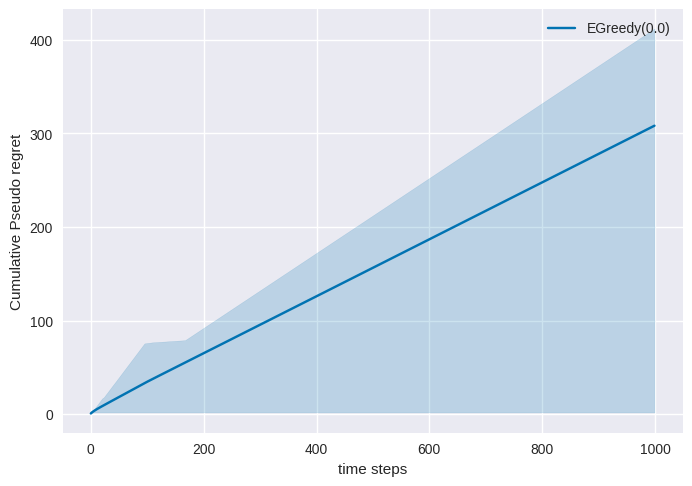

In [11]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="pseudo regret")
plot_result(greedy_experiment, q=10, mode="pseudo regret");

🚀 Now it's time to test you implementation of epsilon greedy!

🤓 Remember: whatever bandit algorithm you use in your application, always make sure to compare it with Greedy first. Sometimes, Greedy (supervised learning) is all your client/boss will be willing to deploy...

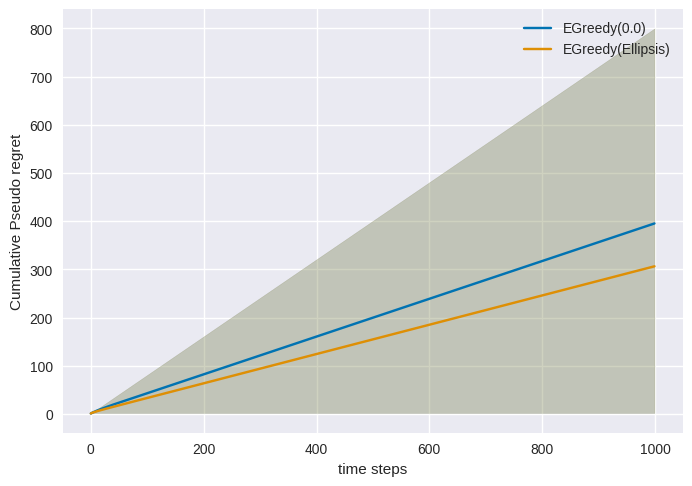

In [12]:
eps_greedy = EpsilonGreedy(K,  eps=...) # Pick your epsilon!

eps_greedy_experiment = experiment_mab(env, [greedy, eps_greedy], N=N, T=T, mode="pseudo regret")
plot_result(eps_greedy_experiment, q=10, mode="pseudo regret");

🤓 Did you find a good value of $\epsilon$? Well, in a real *online* application you have only one trial, so you can't really do hyper-parameter tuning...

## Exercise 1.B &mdash; UCB

**tl;dr**
> $A_t = \arg\max_{a\in\{1,\dots,K\}} \left\{\widehat{\mu}_a(t) + \sqrt{\frac{\alpha \log t}{N_a(t)}}\right\}$

🔧 Now you will have to complete the implementation of UCB:

**After playing each arm once, do:**

$A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$

where the score or *index* of an action is

$F_t(a) = \widehat{\mu}_a(t) + \sqrt{\frac{\alpha \log t}{N_a(t)}}$               

and $N_a(t)$ is the number of times arm $a$ was selected up to time $t$ and $\alpha>0$ is an exploration parameter. In the following code, only the action selection part is missing

In [13]:
class UCB(Agent):
  """
  UCB (Upper Confidence Bound) MAB algorithm

  :param K: number of arms
  :param alpha: scaling of the optimistic bonus (appears under square root)
  """
  def __init__(self, K, alpha):
    self.alpha = alpha
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)


  def reset(self):
    """Reset history before each independent run"""
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)


  def get_action(self):
    """
    Select the arm to play based on current history

    :return: the selected arm (an integer between 0 and K-1)
    """
    # YOUR CODE HERE
    # TODO: Implement the action scores of UCB

    scores = ... # K-dimensional ndarray

    # END OF YOUR CODE

    chosen_arm_index = np.argmax(scores)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (counts and average rewards)

    :param chosen_arm: the arm that was played
    :param reward: the reward that was received
    """
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm]

    self.t += 1

  def name(self):
    return 'UCB('+str(self.alpha)+')'

🚀 It's time to test your implementation of UCB!
* Can you find a good value of $\alpha$? Emilie's slides may help
* How does it perform compared to $\epsilon$-greedy?


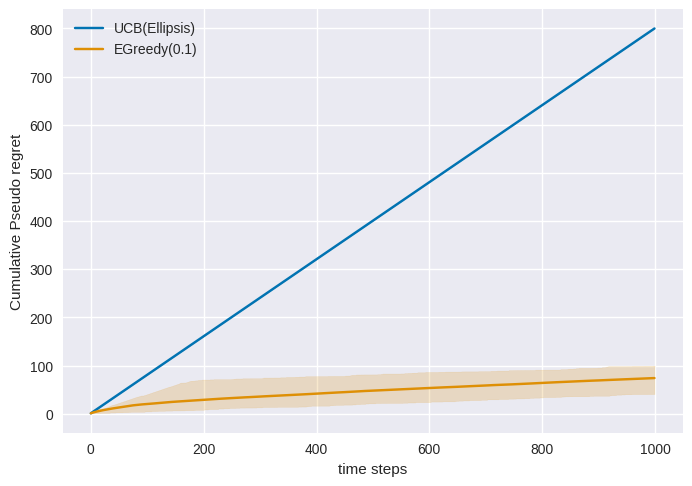

In [14]:
ucb = UCB(K, alpha=...) # Pick your alpha!

epsilon_greedy = solutions.EpsilonGreedy(K,  eps=solutions.EPSILON)
ucb_experiment = experiment_mab(env, [ucb, epsilon_greedy], N=N, T=T, mode="pseudo regret")
plot_result(ucb_experiment, q=10, mode="pseudo regret");

## Exercise 1.C &mdash; Thompson Sampling

**tl;dr**
> $F_{t-1,a} \sim \mathcal{N}\left(\widehat{\mu}_a(t-1), \frac{\sigma^2}{N_a(t-1)}\right)$
>
> $A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$

🔧 You next task is to implement the action-selection rule of Thompson Sampling (TS).

### 📖 Gaussian Thompson Sampling

TS is a *randomized* algorithm. We can still write the selection rule as for index algorithms:

$A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$

but now $F_{t}(a)$ is a randomized quantity:

$F_{t}(a) \sim Q_{t,a}$

where $Q_{t,a}$ is a *posterior distribution* obtained by Bayes' rule:

$Q_{t,a}(F) \propto Q_{t-1,a}(F) \cdot P(R_t | F)$

starting from some given *prior* $Q_{0,a}$ and sequentially updating it (only for the chosen arm) with the *likelihood* of observed rewards (separately for each arm)

In our case *we know* the rewards are gaussian with standard deviation $\sigma=1$, so it is natural to use a Gaussian likelihood:

$P(R_t|\mu_a=F) = \mathcal{N}(F,1)$

and a zero-mean Gaussian prior:

$Q_{0,a} = \mathcal{N}(0,1)$ for all $a$.

By Bayes' rule it's easy to show that the posterior is also Gaussian

$Q_{t,a} = \mathcal{N}\left(\widehat{\mu}_a(t-1), \frac{\sigma^2}{N_a(t-1)}\right)$

where $\sigma=1$ in our case. So you can implement the selection rule of Gaussian TS as follows:

* For each arm $a\in\{1,\dots,K\}$ sample $F_{t-1,a} \sim \mathcal{N}\left(\widehat{\mu}_a(t-1), \frac{\sigma^2}{N_a(t-1)}\right)$
* Play $A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$

🎁 [Hint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)

💪 **Bonus question:** what happens if you use a different prior, for instance a different value of `sigma` ?

In [15]:
class ThompsonSampling(Agent):
  """
  Thompson Sampling MAB algorithm for Gaussian rewards

  :param K: number of arms
  :param sigma: standard deviation of Gaussian prior
  """
  def __init__(self, K, sigma=1.):
    self.sigma = sigma
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)


  def reset(self):
    """Reset history before each independent run"""
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)

  def get_action(self):
    """
    Select the arm to play based on current history

    :return: the selected arm (an integer between 0 and K-1)
    """
    # YOUR CODE HERE
    # TODO: implement the random action scores of Gaussian Thompson Sampling

    scores = ...

    # END OF YOUR CODE

    chosen_arm_index = np.argmax(scores)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (counts and average rewards)

    :param chosen_arm: the arm that was played
    :param reward: the reward that was received
    """
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm]

    self.t += 1

  def name(self):
    return 'TS('+str(self.sigma)+')'

🚀 Now it's time to test your implementation of Thompson sampling on our 3-arm bandit problem. Does it perform better than $\epsilon$-greedy?

And of UCB?

🤓 If you don't see much difference among the different algorithms, you can try with a longer horizon $T$

  Different results every time you run it? Try with a larger number of runs $N$ or seed numpy's random number generator

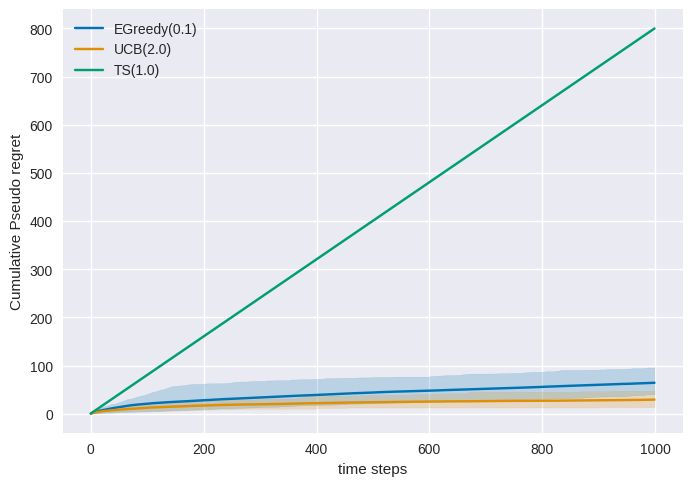

In [16]:
ts = ThompsonSampling(K)

epsilon_greedy = solutions.EpsilonGreedy(K,  eps=solutions.EPSILON)
ucb = solutions.UCB(K, alpha=solutions.ALPHA)
ts_experiment = experiment_mab(env, [epsilon_greedy, ucb, ts], N=N, T=T, mode="pseudo regret")
plot_result(ts_experiment, q=10, mode="pseudo regret");

# Part 2 &mdash; Linear Contextual Bandits

Coming back to our web application, we now want to develop a *personalised* system, taking into account that differnt users may like different versions of the website. We assume that for each pair of user features $u$ and website version $w$, there is a feature map $\phi(u,w) \in \mathcal{R}^d$, such that the reward (engagement score) we get from user $U_t$ interacting with website version $W_t$ is

$R_t=\phi(U_t,W_t)^\top \theta + \epsilon_t$

where $\epsilon_t \sim  N(0, \sigma^2)$ is just standard normal noise.

This is an instance of the *linear bandit* problem introduced in Claire's lecture. The "actions" are now vectors in $R^d$, representing *contextual features* $X_t = \phi(u_t,w)$, and the environment is assumed to generate rewards according to the unknown linear function $R_t = X_t^\top \theta + \epsilon_t$ (parameter $\theta\in\mathbb{R}^d$ is unknown to the agent)

You can imagine that at each time step $t$ our website compares the current user's "type" (based on features like age, location...) with some properties of the $K=3$ versions of our webpage and produces $K$ feature vectors in $\mathbb{R}^d$ ($d=7$), representing the estimated "affinity" of the current user with each of the $K$ versions. There are only $2$ user types in our example below.

The underlying assumption is that these feature vectors are expressive enough so that the reward will be a linear function of these known "actions" with the unknown parameter $\theta$

Here is some code to run linear-bandit experiments, with a similar interface to the one we have used for MAB. We will visualize **pseudo-regret**.

In [17]:
class LinearBandit(Environment):
  """
  (Contextual) Linear Bandit instance

  :param theta: unknown d-dimensional parameter of linear rewards
  :param K: number of arms (feature vectors) per round
  :param n_contexts: total number of possible contexts (different feature vectors per arm per round)
  :param var: standard deviation of Gaussian noise
  """
  def __init__(self, theta, K, n_contexts, var=1.):
      self.d = np.size(theta)
      self.theta = theta
      self.K = K
      self.var = var
      self.n_contexts = n_contexts

      self.features = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=(self.n_contexts, K))
      self.features = self.features
      norms = np.linalg.norm(self.features, axis=2)
      self.features = self.features / norms[:, :, np.newaxis]
      current_context_id = np.random.randint(self.n_contexts)
      self.current_action_set = self.features[current_context_id, :, :]

  def get_action_set(self):
      """Returns the set of available arms (feature vectors) for the current round"""
      current_context_id = np.random.randint(self.n_contexts)
      self.current_action_set = self.features[current_context_id, :, :]
      return self.current_action_set

  def get_reward(self, action):
      """
      Sample a random reward

      :param action: the arm (d-dimensional feature vector) chosen by the learner)
      """
      mean = np.dot(action, self.theta)
      return np.random.normal(mean, scale=self.var)

  def get_means(self):
      """Returns the mean rewards of all the available arms"""
      return np.dot(self.current_action_set, self.theta)

In [18]:
def play_linb(environment, agent, N, T):
    """
    Play N independent runs of length T for the specified agent.

    :param environment: a linear bandit instance
    :param agent: a contextual bandit algorithm
    :param N: number of independent simulations
    :param T: decision horizon
    :return: the agent's name, and the collected data in an ndarray
    """

    data = np.zeros((N, T))


    for n in range(N):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            # Note that, differently from the previous part, now get_action needs to receive the action_set
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # Compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n,t]= best_reward - np.dot(action, environment.theta) # pseudo regret

    return agent.name(), data


def experiment_linb(environment, agents, N, T):
    """
    Play N trajectories for all agents over a horizon T. Store data in a dictionary.

    :param environment: a linear bandit instance
    :param agent: a list of contextual bandit algorithms to compare
    :param N: number of independent simulations
    :param T: decision horizon
    :return: the pseudo regret for each agent in a dictionary indexed by the agent's name
    """

    all_data = {}

    for agent in agents:
        agent_id, regrets = play_linb(environment, agent, N, T)

        all_data[agent_id] = regrets

    return all_data

Here is the specification of our linear bandit problem

In [19]:
d = 7  # Feature dimension
K = 3 # Number of arms per timestep (number of website versions)
n_contexts = 2 # Number of contexts (types of users)
theta = np.random.normal(0., 1., size=d)
theta = theta / np.linalg.norm(theta)

T = 1000  # Finite Horizon
N = 50  # Monte Carlo simulations

# The parameter theta is unknown, but we know it's been normalized (the l2 norm of theta is 1)
# Feature vectors are also normalized
lin_env = LinearBandit(theta, K, n_contexts)


# Save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)
# Choice of percentile display
q = 10

## Exercise 2.A &mdash; Linear $\epsilon$-greedy

**tl;dr**
> $X_t = \arg \max_{x \in \mathcal{X}_t}\left\{ x^T \hat{\theta}_t\right\} $ with probability $1-\epsilon$
>
> $X_t \sim \mathrm{Uniform}(\mathcal{X}_t)$ otherwise

🔧 Your next task is to complete the implementation of the action selection rule of Linear $\epsilon$-greedy. You can reuse some of your code from your implementation of $\epsilon$-greedy for MABs.

👁️ The main difference compared to the MAB case is that `get_action` has an input `arms` ($\mathcal{X}_t$ in the pseudocode below) that is the set of $d$-dimensional feature vectors generated by the environment at time $t$.

📖 The selection rule is:

* Play $X_t = \arg \max_{x \in \mathcal{X}_t} x^T \hat{\theta}_t $ with probability $1-\epsilon$
* Play $X_t$ sampled uniformly at random from $\mathcal{X}_t$ instead

where $\hat{\theta}_t$ is the *least squares estimate* of the unknown parameter $\theta$ based on all the arms played so far and the corresponding collected rewards:

$\widehat{\theta}_t = V_{t}^{-1}b_t$

where $b_t$ is the *target vector*

$b_t=\sum_{s=1}^{t-1}X_{t}R_{t}$

and $V_{t}$ is the $\lambda$-regularized *covariance matrix*

$V_{t}=\lambda I + \sum_{s=1}^{t-1}X_{t}X_{t}^T$

🎁 [Hint](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)

💪 **Bonus exercise:** instead of inverting the covariance matrix at each step, you could update it incrementally using the [Sherman-Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula). You can reuse this trick for LinUCB below (any practical implementation of LinUCB should use this implementation!)   

In [20]:
class LinEpsilonGreedy(Agent):
  """
  Linear epsilon-Greedy contextual-bandit algorithm

  :param d: feature dimension
  :param lambda_reg: regularization parameter for regularized least-squares
  :eps: exploration probability
  """
  def __init__(self, d,lambda_reg=1., eps=0.1,):
    self.eps = eps # exploration probability
    self.d = d
    self.lambda_reg = lambda_reg
    self.reset()

  def reset(self):
    """Reset history before each independent run"""
    self.t = 0

    # The covariance matrix is initialized here
    self.cov = self.lambda_reg * np.identity(self.d)

    # The inverse of the covariance matrix is initialized here
    self.invcov = np.identity(self.d)

    # The target vector is initialized here
    self.b_t = np.zeros(self.d)

    # The parameter estimate is initialized here
    self.hat_theta = np.zeros(self.d)


  def get_action(self, arms):
    """
    Select the arm (feature vector) to play based on current history

    :param arms: the set of available arms (feature vectors)
    :return: the selected arm (a d-dimensional feature vector)
    """
    K, _ = arms.shape

    u = np.random.random()
    if u<self.eps:
        return arms[np.random.choice(K)]
    else:
        # YOUR CODE HERE
        # TODO: add the "greedy" action selection rule

        return arms[0] # REPLACE THIS!

        # END OF YOUR CODE

  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (least squares estimate)

    :param chosen_arm: the arm (feature vector) that was played
    :param reward: the reward that was received
    """

    # YOUR CODE HERE
    # TODO: Update the covariance matrix, its inverse, the target vector, and the parameter estimate

    self.cov = ...

    self.invcov = ...

    self.b_t = ...

    self.hat_theta = ...

    # END OF YOUR CODE

    self.t += 1

  def name(self):
    return 'LinEGreedy('+str(self.eps)+')'

You can test Linear $\epsilon$-greedy here.

🤓 Don't forget to compare it with the greedy version ($\epsilon=0$)

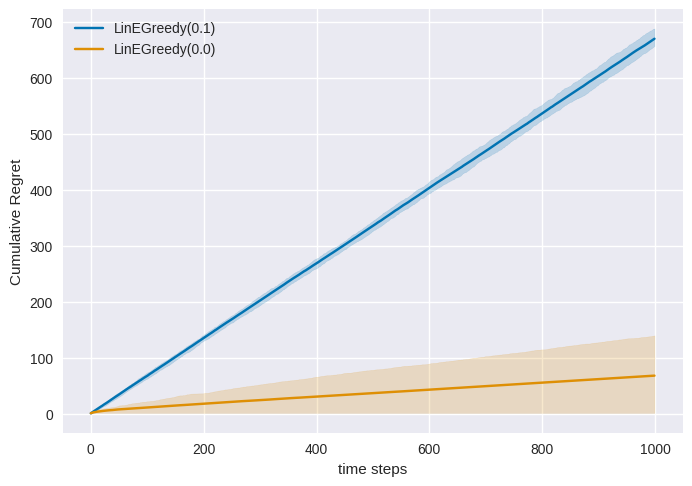

In [21]:
lin_eps_greedy = LinEpsilonGreedy(d, eps=0.1)

lin_greedy = solutions.LinEpsilonGreedy(d, eps=0.)
lin_eps_greedy_experiment = experiment_linb(lin_env, [lin_eps_greedy, lin_greedy], N=N, T=T)
plot_result(lin_eps_greedy_experiment);

## Exercise 2.B &mdash; LinUCB

**tl;dr**
> $X_t = \arg \max_{x \in \mathcal{X}_t}\left\{ x^T \widehat{\theta_t} + \alpha\beta_t \sqrt{x^T V_t^{-1} x}\right\}$

🔧 Time to implement LinUCB! You can reuse your implementation of `receive_reward` from `LinEpsilonGreedy`.

📖 The selection rule of LinUCB is:

* $F_t(x) = x^T \widehat{\theta_t} + \alpha\beta_t \sqrt{x^T V_t^{-1} x}$

* Play $X_t = \arg\max_x F_t(x)$

where we have already coded the "theoretical" exploration parameter $\beta_t$ for you (compared to Claire's slides, we have $S=L=1$ here)

$\beta_t = \sqrt{\lambda} + \sqrt{2\log\left(\frac{1}{\delta}\right)+d\log\left(1+\frac{t}{\lambda d}\right)}$

🤓 You can use the hyper-parameter $\alpha$ to rescale the exploration bonus (smaller exploration bonuses may work better in practice...)

💪 **Bonus questions**:
* Can you use a smaller exploration parameter $\beta_t$ in such a way that the regret guarantees of LinUCB are preserved? You can find the right idea in Claire's slides.
* Play with different values of $d$, $K$, and n_contexts. What happens when the feature dimension $d$ is small in comparison?

In [22]:
class LinUCB(Agent):
  """
  LinUCB (Linear Upper Confidence Bound) contextual-bandit algorithm for subgaussian rewards

  :param d: feature dimension
  :param delta: failure probability
  :param lambda_reg: regularization parameter for regularized least-squares
  :alpha: heuristic scaling of the exploration bonus
  """

  def __init__(self, d, delta, lambda_reg, alpha=1.):
    self.d = d
    self.delta = delta
    self.lambda_reg = lambda_reg
    self.cov = self.lambda_reg * np.identity(d)


    self.alpha = alpha
    self.reset()

  def reset(self):
    """Reset history before each independent run"""
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.b_t = np.zeros(self.d)


  def get_action(self, arms):
    """
    Select the arm (feature vector) to play based on current history

    :param arms: the set of available arms (feature vectors)
    :return: the selected arm (a d-dimensional feature vector)
    """
    K, _ = arms.shape
    self.UCBs = np.zeros(K)

    self.beta = np.sqrt(self.lambda_reg) + np.sqrt(2*np.log(1./self.delta) + np.log(1+self.t/(self.d*self.lambda_reg)))

    # YOUR CODE HERE
    # TODO: Compute the action scores (self.UCBs)

    ...

    # END OF YOUR CODE

    chosen_arm_index = np.argmax(self.UCBs)
    chosen_arm = arms[chosen_arm_index]
    return chosen_arm


  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (least squares estimate)

    :param chosen_arm: the arm (feature vector) that was played
    :param reward: the reward that was received
    """
    # YOUR CODE HERE
    #TODO: same as Linear epsilon-Greedy

    ...

    # END OF YOUR CODE
    self.t += 1

    pass


  def name(self):
    return "LinUCB("+str(self.alpha)+')'

🚀 Time to test your implementation of LinUCB! Is it better than ($\epsilon$-)greedy?

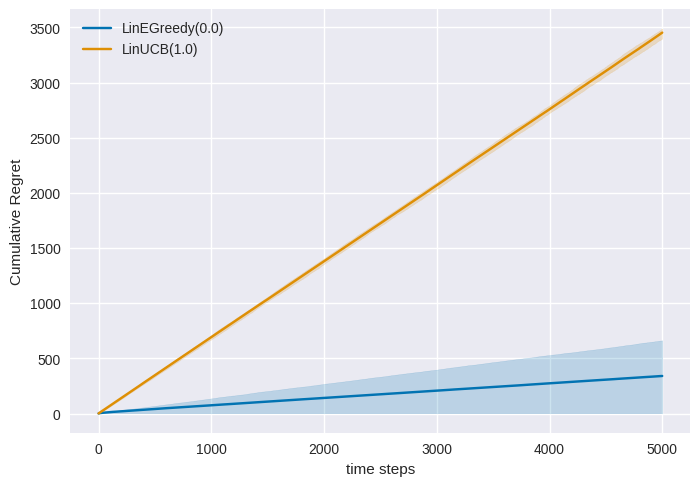

In [23]:
linucb = LinUCB(d, delta=0.2, lambda_reg=1., alpha=1.) #You can try alpha < 1

linear_epsilon_greedy = solutions.LinEpsilonGreedy(d, eps=0.)
lin_ucb_experiment = experiment_linb(lin_env, [linear_epsilon_greedy, linucb], N=N, T=5*T)
plot_result(lin_ucb_experiment);

## Exercise 2.C (💪 BONUS) &mdash; LinTS

Implement linear TS. You can find our solution in `solutions.LinTS`. How does it perform compared to LinUCB?

In [24]:
class LinTS(Agent):
  """
  LinTS (Linear Thompson Sampling) contextual-bandit algorithm for Gaussian rewards

  :param d: feature dimension
  :param delta: failure probability
  :param lambda_reg: regularization parameter for regularized least-squares
  :alpha: heuristic scaling of the exploration bonus
  """

  def __init__(self, d, delta, lambda_prior):
    self.d = d
    self.delta = delta
    self.lambda_prior = lambda_prior
    self.cov = self.lambda_prior * np.identity(d)
    self.reset()

  def reset(self):
    """Reset history before each independent run"""
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_prior * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.b_t = np.zeros(self.d)


  def get_action(self, arms):
    """
    Select the arm (feature vector) to play based on current history

    :param arms: the set of available arms (feature vectors)
    :return: the selected arm (a d-dimensional feature vector)
    """
    K, _ = arms.shape
    estimated_means = np.zeros(K)

    # YOUR CODE HERE
    # TODO: Compute the mean estimates
    ...

    # END OF CODE SOLUTION

    chosen_arm_index = np.argmax(estimated_means)
    chosen_arm = arms[chosen_arm_index]


    return chosen_arm



  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (least squares estimate)

    :param chosen_arm: the arm (feature vector) that was played
    :param reward: the reward that was received
    """
    # YOUR CODE HERE
    # TODO: same as Linear epsilon-Greedy
    ...

    # END OF CODE SOLUTION

    self.t += 1

    pass


  def name(self):
    return "LinTS"

Here you can test your implementation of LinTS

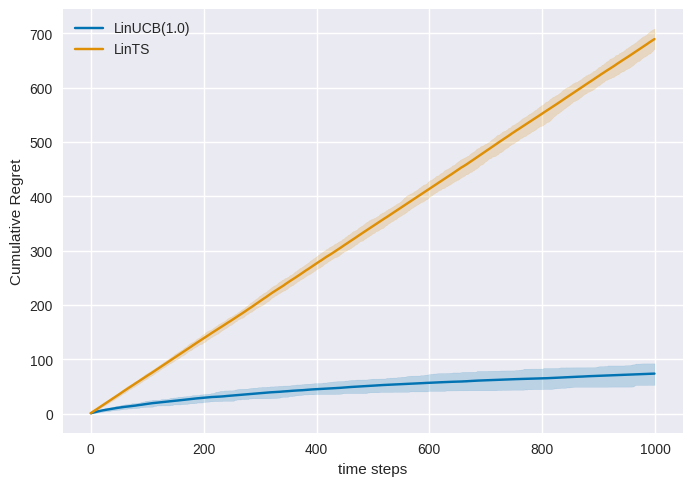

In [25]:
lints = LinTS(d, 0.2, 1.)

linucb = solutions.LinUCB(d, delta=0.2, lambda_reg=1., alpha=1.)
lin_ts_experiment = experiment_linb(lin_env, [linucb, lints], N=N, T=T)
plot_result(lin_ts_experiment);